## 本文档用于图像与城市语义特征的聚类分析，包含以下关键步骤：

### 1. 数据准备：提取图像的 RGB 特征，并融合 GWR 加权得到的城市语义向量
- 图像数据来源于 patch 周边的城市形态渲染图
- 城市语义向量包括地理加权回归得到的权重指标，用于增强聚类的空间语义表达

### 2. 特征处理：使用卷积神经网络（CNN）提取图像特征向量
- 可使用预训练模型（如 ResNet、VGG）提取高维图像嵌入
- 对语义向量进行标准化处理后拼接进图像特征

### 3. 聚类前评估：使用平均轮廓系数法（Silhouette Score）评估最优聚类数 K
- 遍历不同 K 值，绘制轮廓系数曲线
- 选择得分最高或变化平稳的 K 作为最终聚类数

### 4. 降维与可视化：使用主成分分析（PCA）对高维特征进行 2D 或 3D 映射
- 降维后绘制散点图，查看不同聚类的空间分布
- 分析各主成分的含义（如城市形态 vs. 功能语义）

### 5. 聚类分析：应用 KMeans 等聚类算法对图像+语义向量进行聚类
- 保存聚类标签，评估每类的代表性与空间分布

### 6. 聚类结果输出与解释
- 将聚类标签映射回原始 patch 图像与 GeoDataFrame 中
- 可视化聚类分布、类别图像示例、以及与城市变量的关系

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import box,Polygon,Point
import os


#### 1. 数据准备：提取图像的 RGB 特征，并融合 GWR 加权得到的城市语义向量

In [17]:
def square_buffer(center_point, half_size=300):
    x, y = center_point.x, center_point.y
    return box(x - half_size, y - half_size, x + half_size, y + half_size)

building = gpd.read_file("processing_data/img/building_black").to_crs(epsg=32632)
farming = gpd.read_file("processing_data/img/farming_green").to_crs(epsg=32632)
processing = gpd.read_file("processing_data/img/processing_red").to_crs(epsg=32632)
road = gpd.read_file("processing_data/img/road_grey").to_crs(epsg=32632)
water = gpd.read_file("processing_data/img/water_blue").to_crs(epsg=32632)

processing_center = processing.unary_union.centroid

# output_dir = "playground/Render_Images"
output_dir = "playground/Render_Images"
os.makedirs(output_dir, exist_ok=True)


# 4. 渲染函数：以一个点为中心，裁剪5km范围并渲染图像
def render_one_image(center_point, index):
    buffer = square_buffer(center_point, half_size=500)
    def clip_layer(gdf): return gdf[gdf.geometry.intersects(buffer)]

    bld_clip = clip_layer(building)
    farm_clip = clip_layer(farming)
    proc_clip = clip_layer(processing)
    road_clip = clip_layer(road)
    water_clip = clip_layer(water)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_facecolor("white")

    # 顺序渲染
    water_clip.plot(ax=ax, color='blue', edgecolor='none')
    farm_clip.plot(ax=ax, color='green', edgecolor='none')
    road_clip.plot(ax=ax, color='grey', linewidth=5)
    bld_clip.plot(ax=ax, color='black', edgecolor='none')
    proc_clip.plot(ax=ax, color='red')

    ax.set_xlim(buffer.bounds[0], buffer.bounds[2])
    ax.set_ylim(buffer.bounds[1], buffer.bounds[3])
    ax.axis("off")

    plt.tight_layout()
    save_path = os.path.join(output_dir, f"render_{index:03d}.png")
    plt.savefig(save_path, dpi=300)
    plt.close()

    # 5. 遍历 processing 图层的每个 geometry（通常是 Polygon 或 Point）
for idx, row in processing.iterrows():
    center = row.geometry.centroid
    render_one_image(center, idx)

print(f"✅ 共生成 {len(processing)} 张图，保存在 {output_dir}/ 中")

C:\Users\Elena\AppData\Local\Temp\ipykernel_4840\565142555.py:11: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  processing_center = processing.unary_union.centroid
C:\Users\Elena\AppData\Local\Temp\ipykernel_4840\565142555.py:33: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  water_clip.plot(ax=ax, color='blue', edgecolor='none')
C:\Users\Elena\AppData\Local\Temp\ipykernel_4840\565142555.py:33: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  water_clip.plot(ax=ax, color='blue', edgecolor='none')
C:\Users\Elena\AppData\Local\Temp\ipykernel_4840\565142555.py:33: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  water_clip.plot(ax=ax, color='blue', edgecolor='none')
C:\Users\Elena\AppData\Local\Temp\ipykernel_4840\565142555.py:35: UserWarning: The GeoDataFrame you are attempting to plot is

✅ 共生成 58 张图，保存在 playground/Render_Images/ 中


In [4]:
from PIL import Image
import numpy as np
import os

image_folder = "playground\Render_Images"
img_list = []

for i in range(58):
    img = Image.open(os.path.join(image_folder, f"render_{i:03d}.png")).resize((224, 224)).convert("RGB")
    img_array = np.array(img) / 255.0
    img_list.append(img_array)

img_array_all = np.stack(img_list)  # shape: (58, 224, 224, 3)

### 获取城市语义

In [38]:


from sklearn.preprocessing import StandardScaler
processing = gpd.read_file("processing_data/img/processing_red").to_crs(epsg=32632)

# === Step 1: 读取数据 ===
patches_with_gwr = gpd.read_file("patches_with_gwr.geojson")
processing["centroid"] = processing.geometry.centroid
centroids = processing.copy()
centroids.set_geometry("centroid", inplace=True)
centroids = centroids.reset_index().rename(columns={"index": "proc_index"})

# === Step 2: 使用空间连接找出每个 processing 所在的 patch ===
matched = gpd.sjoin(centroids, patches_with_gwr, how="left", predicate="within")

# 确保顺序一致，保留 original processing 顺序
matched = matched.sort_values("proc_index").reset_index(drop=True)
print(len(matched))
beta_cols = [
    'beta_farming_area_norm',
    'beta_aquaculture_area_norm',
    # 'beta_pasture_area_norm',
    # 'beta_energy_area_norm',
    'beta_transportation_area_norm',
    # 'beta_retail_count_norm',
    'beta_public_services_norm',
    'beta_waste_treatment_norm',
    'beta_road_length_norm',
    'beta_built_area_norm',
    # 'beta_entropy_production',
    'beta_entropy_landuse',
]
# 逐列相乘得到“机制语义向量”
mechanism_features = []

# 单独取相关性系数
for beta in beta_cols:
    # raw_val = patches_with_gwr[raw].astype(float)
    beta_val =  matched[beta].astype(float)
    beta_scaled = StandardScaler().fit_transform(beta_val.values.reshape(-1, 1)).flatten()
    mechanism_features.append(beta_scaled)

# 拼接成新的 DataFrame,机制语义向量
X_mechanism = np.stack(mechanism_features, axis=1)
print(len(X_mechanism))
print(X_mechanism)

58
58
[[ 0.20322869  0.53068562  0.80844557 -1.00144464 -0.38996808 -0.99329824
   0.98300388  0.32923327]
 [ 0.42354363 -2.26348945  0.55920531  1.53390291  0.58539591  0.35442637
  -1.0326024  -0.59559736]
 [ 0.21028823 -0.25009923 -0.5019235  -0.66001342 -0.41004557 -1.17622006
   0.7721523   1.27622283]
 [ 1.84632379 -1.41270157  0.99311408  1.60268985  0.25578696  0.89962118
  -1.69431869 -0.72354317]
 [ 1.26285227 -2.04764485  0.70507473  1.52403582  0.32593415  0.82150102
  -1.48566342 -0.75477595]
 [ 0.20822301  0.52799289 -0.64427748 -0.72329492 -0.40884639 -0.81604717
   0.56982832  1.20583404]
 [-1.12721247  0.36639824  0.04863276  1.04991298  0.52171453  0.88062717
  -1.05973337 -0.24523691]
 [ 0.24469401  0.06316512 -1.05307088 -0.48226866 -0.41990838 -0.9100891
   0.39751861  1.62160515]
 [-1.083789    0.61184321 -0.01836544  0.93790163  0.57152512  1.13128534
  -1.01929486 -0.92340926]
 [ 0.18399367  0.08468172  1.35040678 -1.08697023 -0.38733046 -1.29336924
   1.2489782

#### 利用CNN把图像压缩为512维度,pca降维至4维

In [6]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms

# 使用预训练的 ResNet18 来提取图像特征 embedding
model = models.resnet18(pretrained=True)
model.fc = torch.nn.Identity()  # 去掉分类头，保留特征输出
model.eval()

# 转换图像为 tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

features = []

with torch.no_grad():
    for img in img_list:
        x = transform(Image.fromarray((img * 255).astype(np.uint8)))
        x = x.unsqueeze(0)  # batch 维度
        feat = model(x).squeeze().numpy()
        features.append(feat)

X = np.stack(features)  # shape: (60, 512)

print(X.shape)
print(X)

D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


(58, 512)
[[0.4626822  0.14098874 2.6038659  ... 0.4841269  0.         0.36364338]
 [0.22254357 0.19255354 1.0974758  ... 0.76207066 0.03701104 0.54134166]
 [0.04944006 0.324011   1.1066251  ... 0.1979135  0.09934146 0.26943552]
 ...
 [0.728299   0.7215442  0.5658069  ... 0.91597414 0.01850705 0.9196329 ]
 [0.07128474 0.67886233 1.087907   ... 0.90248257 0.17137517 1.1880276 ]
 [0.29092374 0.61232996 1.6606075  ... 0.25188473 0.2993764  0.31982026]]


In [39]:
from sklearn.decomposition import PCA

pca = PCA(n_components=7)
X_pca = pca.fit_transform(X)
scaler = StandardScaler()
X_pca = scaler.fit_transform(X_pca)
print(X_pca)

[[ 0.74625105  0.62610453 -1.2983456   2.1675856  -1.2444973  -1.9342562
  -0.02425583]
 [-1.0114391  -0.23627438  0.55424947 -0.2929558  -1.1766692   2.3492665
   0.24102084]
 [-0.93282     0.12246365  0.0947261  -0.15719001 -0.1042584   1.0399184
   0.3996717 ]
 [ 0.1925531  -0.14787105 -0.23460115  0.7554623   0.79766536 -0.5091535
   0.04211508]
 [-0.7693694   0.5740813   0.8500773  -0.994474   -0.080346    1.3442012
  -0.44765517]
 [-1.7844086  -0.96467745  0.89409494  0.6053992   0.7683334   0.26322708
   0.30839324]
 [-0.6897848  -0.6940526  -0.20661387 -1.8833613  -0.83774054 -1.0030284
   0.5642451 ]
 [ 0.27411523  1.4149696  -0.49232385 -0.67652464  0.24323207 -0.77567285
   0.8998342 ]
 [ 0.41671786  1.2207793  -0.24544047 -1.3490639  -0.47280642  0.80340624
  -0.49236795]
 [-0.9049325   0.9145053  -1.5338304  -0.79882795 -0.89023656 -0.51902026
   0.7708356 ]
 [-1.0479077  -0.97022265 -0.87864536 -1.4761492   0.27158815 -1.3759333
   0.65264827]
 [ 0.04510916 -0.3932165  -0

In [40]:
from sklearn.preprocessing import StandardScaler
StandardScaler().fit_transform(X_mechanism)
X_final= np.hstack([X_pca, X_mechanism])
print(X_final.shape)
print(X_final)

(58, 15)
[[ 0.74625105  0.62610453 -1.29834557  2.16758561 -1.2444973  -1.9342562
  -0.02425583  0.20322869  0.53068562  0.80844557 -1.00144464 -0.38996808
  -0.99329824  0.98300388  0.32923327]
 [-1.01143909 -0.23627438  0.55424947 -0.29295579 -1.17666924  2.34926653
   0.24102084  0.42354363 -2.26348945  0.55920531  1.53390291  0.58539591
   0.35442637 -1.0326024  -0.59559736]
 [-0.93282002  0.12246365  0.0947261  -0.15719001 -0.1042584   1.03991842
   0.3996717   0.21028823 -0.25009923 -0.5019235  -0.66001342 -0.41004557
  -1.17622006  0.7721523   1.27622283]
 [ 0.1925531  -0.14787105 -0.23460115  0.75546229  0.79766536 -0.50915349
   0.04211508  1.84632379 -1.41270157  0.99311408  1.60268985  0.25578696
   0.89962118 -1.69431869 -0.72354317]
 [-0.76936942  0.5740813   0.85007727 -0.99447399 -0.080346    1.34420121
  -0.44765517  1.26285227 -2.04764485  0.70507473  1.52403582  0.32593415
   0.82150102 -1.48566342 -0.75477595]
 [-1.78440857 -0.96467745  0.89409494  0.60539919  0.7683

#### 利用平均轮廓系数找到最佳的 K 值

### 对比不同的降维维度

D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\sklearn\cluster\_kmeans.py:14

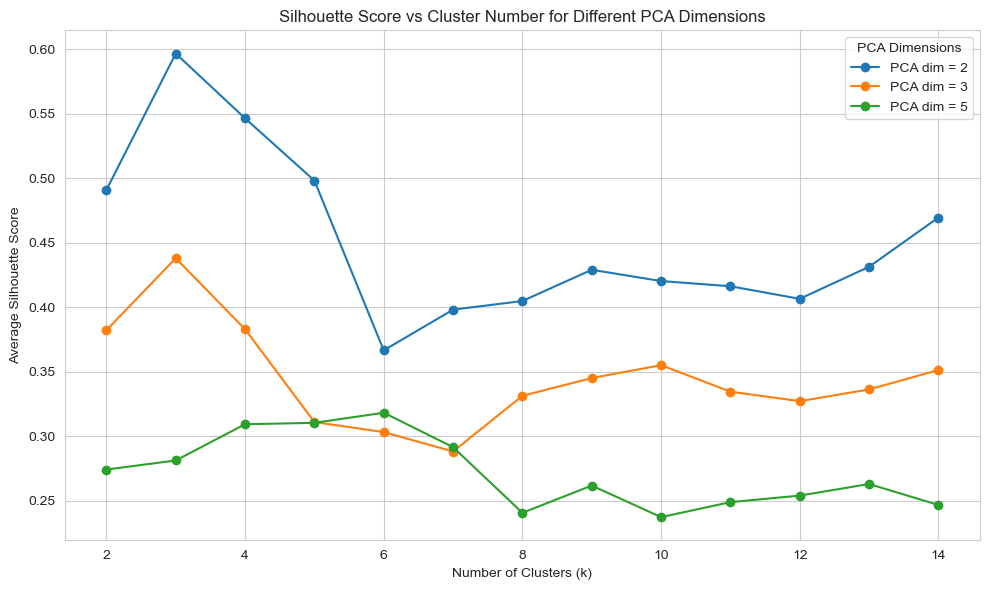

In [11]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import SpectralClustering

# 参数设置
pca_dims = [2, 3, 5]
k_range = range(2, 15)

# 储存结果
results = {}

# 主循环
for dim in pca_dims:
    pca = PCA(n_components=dim)
    X_pca = pca.fit_transform(X_final)
    silhouette_scores = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        # clustering = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', random_state=42)
        labels = kmeans.fit_predict(X_pca)
        # labels = clustering.fit_predict(X_pca)
        score = silhouette_score(X_pca, labels)
        silhouette_scores.append(score)

    results[dim] = silhouette_scores

# 可视化
plt.figure(figsize=(10, 6))
for dim, scores in results.items():
    plt.plot(k_range, scores, marker='o', label=f'PCA dim = {dim}')

plt.title("Silhouette Score vs Cluster Number for Different PCA Dimensions")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Average Silhouette Score")
plt.legend(title="PCA Dimensions")
plt.grid(True)
plt.tight_layout()
plt.show()


[[ 0.74625105  0.62610453 -1.29834557  2.16758561 -1.2444973  -1.9342562
  -0.02425583  0.20322869  0.53068562  0.80844557 -1.00144464 -0.38996808
  -0.99329824  0.98300388  0.32923327]
 [-1.01143909 -0.23627438  0.55424947 -0.29295579 -1.17666924  2.34926653
   0.24102084  0.42354363 -2.26348945  0.55920531  1.53390291  0.58539591
   0.35442637 -1.0326024  -0.59559736]
 [-0.93282002  0.12246365  0.0947261  -0.15719001 -0.1042584   1.03991842
   0.3996717   0.21028823 -0.25009923 -0.5019235  -0.66001342 -0.41004557
  -1.17622006  0.7721523   1.27622283]
 [ 0.1925531  -0.14787105 -0.23460115  0.75546229  0.79766536 -0.50915349
   0.04211508  1.84632379 -1.41270157  0.99311408  1.60268985  0.25578696
   0.89962118 -1.69431869 -0.72354317]
 [-0.76936942  0.5740813   0.85007727 -0.99447399 -0.080346    1.34420121
  -0.44765517  1.26285227 -2.04764485  0.70507473  1.52403582  0.32593415
   0.82150102 -1.48566342 -0.75477595]
 [-1.78440857 -0.96467745  0.89409494  0.60539919  0.76833338  0.2

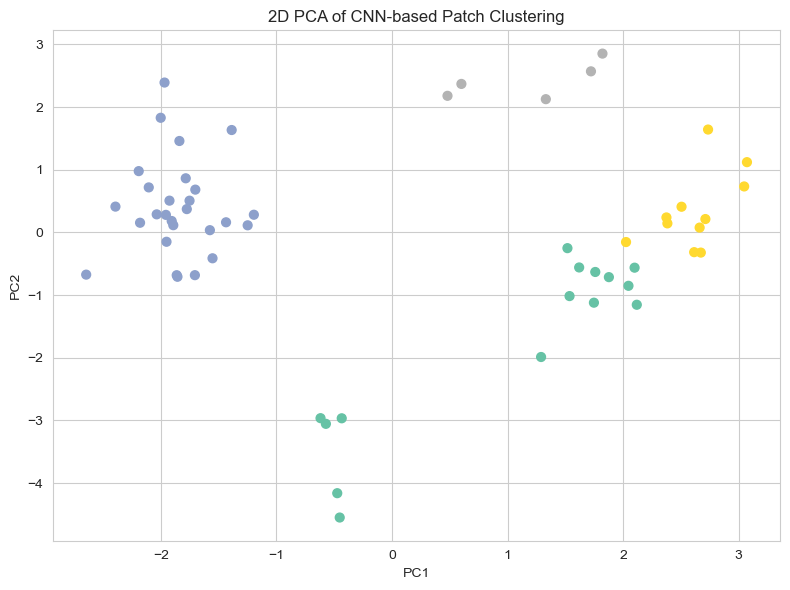

                 PC1       PC2
feature_0   0.136624 -0.189894
feature_1   0.116930 -0.180369
feature_2   0.098131 -0.085817
feature_3  -0.143269  0.034690
feature_4  -0.129774 -0.245064
feature_5   0.102913  0.015786
feature_6   0.096312  0.033590
feature_7   0.030722  0.111324
feature_8  -0.262520 -0.454434
feature_9   0.190363  0.485647
feature_10  0.462932  0.015047
feature_11  0.252935  0.433958
feature_12  0.409660 -0.345578
feature_13 -0.395868  0.291669
feature_14 -0.438046  0.116657


In [45]:
from matplotlib.pyplot import scatter
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import SpectralClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering



pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_final)
print(X_final)
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_final)
n_clusters = 4 # 你可以试着调成 3～6
# kmeans = KMeans(n_clusters=n_clusters, random_state=42)
# labels = kmeans.fit_predict(X_pca)
# clustering = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', random_state=42)
# labels = clustering.fit_predict(X)
model = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')  # linkage 可以是 'ward', 'average',
labels = model.fit_predict(X_pca)  # X_pca 是你降维后的特征向量

# # 画3D散点图
# fig = plt.figure(figsize=(10, 7))
# ax = fig.add_subplot(111, projection='3d')
# scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
#                      c=labels, cmap='Set2', s=40)
# ax.set_title("3D PCA of CNN-based Patch Clustering")
# ax.set_xlabel("PC1")
# ax.set_ylabel("PC2")
# ax.set_zlabel("PC3")
# legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
# ax.add_artist(legend1)
#
# plt.tight_layout()
# # plt.show()
# # 每个主成分在原始特征上的权重（loading matrix）
# loadings = pd.DataFrame(
#     pca.components_.T,
#     columns=['PC1', 'PC2', 'PC3'],
#     index=[f'feature_{i}' for i in range(X_final.shape[1])]  # 用你自己的变量名更好
# )
#
# print(loadings)


# 如果聚类为2维，画散点图
plt.figure(figsize=(8, 6))
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=labels, cmap='Set2', s=40)
plt.title("2D PCA of CNN-based Patch Clustering")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)

# 添加图例
# handles, _ = scatter.legend_elements()
# plt.legend(handles, [f"Cluster {i}" for i in np.unique(labels)], title="Clusters")

plt.tight_layout()
plt.show()

# 每个主成分在原始特征上的权重（loading matrix）
loadings = pd.DataFrame(
    pca_2d.components_.T,
    columns=['PC1', 'PC2'],
    index=[f'feature_{i}' for i in range(X_final.shape[1])]  # 用你自己的变量名更好
)

print(loadings)

### 尝试选出合理的聚类算法

D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\sklearn\cluster\_kmeans.py:14

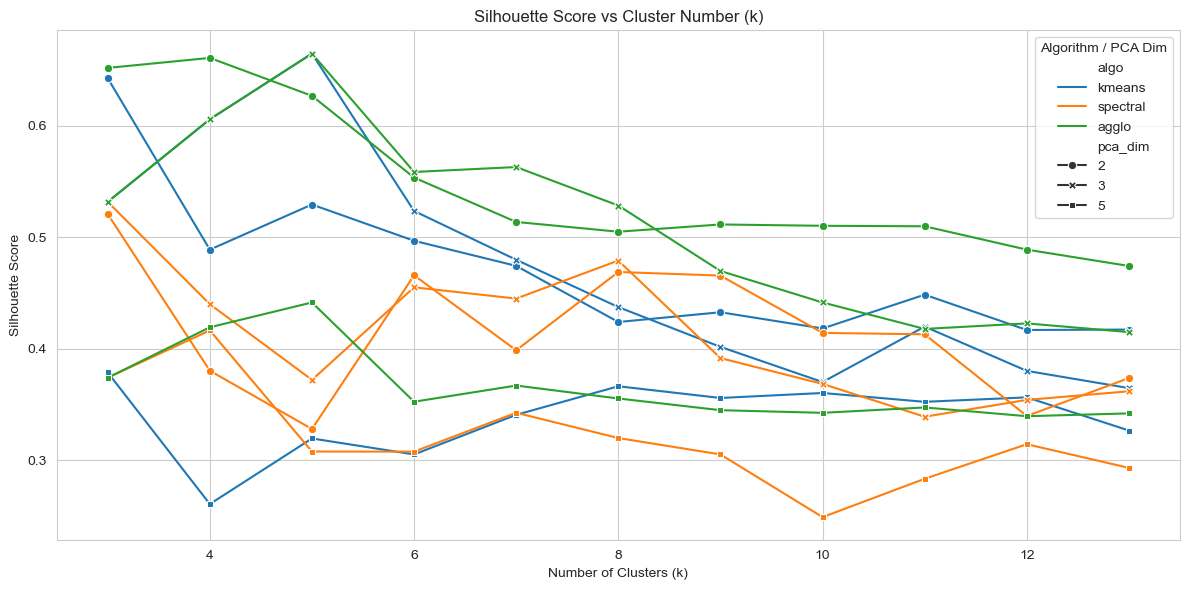

In [41]:

import seaborn as sns
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import SpectralClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

algorithms = ['kmeans', 'spectral', 'agglo']
results = []

for algo in algorithms:
    for dim in [2, 3, 5]:
        X_pca = PCA(n_components=dim).fit_transform(X_final)
        for k in range(3, 14):
            try:
                if algo == 'kmeans':
                    model = KMeans(n_clusters=k, random_state=42)
                elif algo == 'spectral':
                    model = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', random_state=42)
                elif algo == 'agglo':
                    model = AgglomerativeClustering(n_clusters=k, linkage='ward')

                labels = model.fit_predict(X_pca)
                score = silhouette_score(X_pca, labels)

                # 保存
                results.append({
                    'algo': algo,
                    'pca_dim': dim,
                    'k': k,
                    'score': score
                })

            except Exception as e:
                print(f"{algo}, PCA={dim}, k={k} failed: {e}")

df = pd.DataFrame(results)

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='k', y='score', hue='algo', style='pca_dim', markers=True, dashes=False)
plt.title("Silhouette Score vs Cluster Number (k)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.legend(title="Algorithm / PCA Dim")
plt.grid(True)
plt.tight_layout()
plt.show()

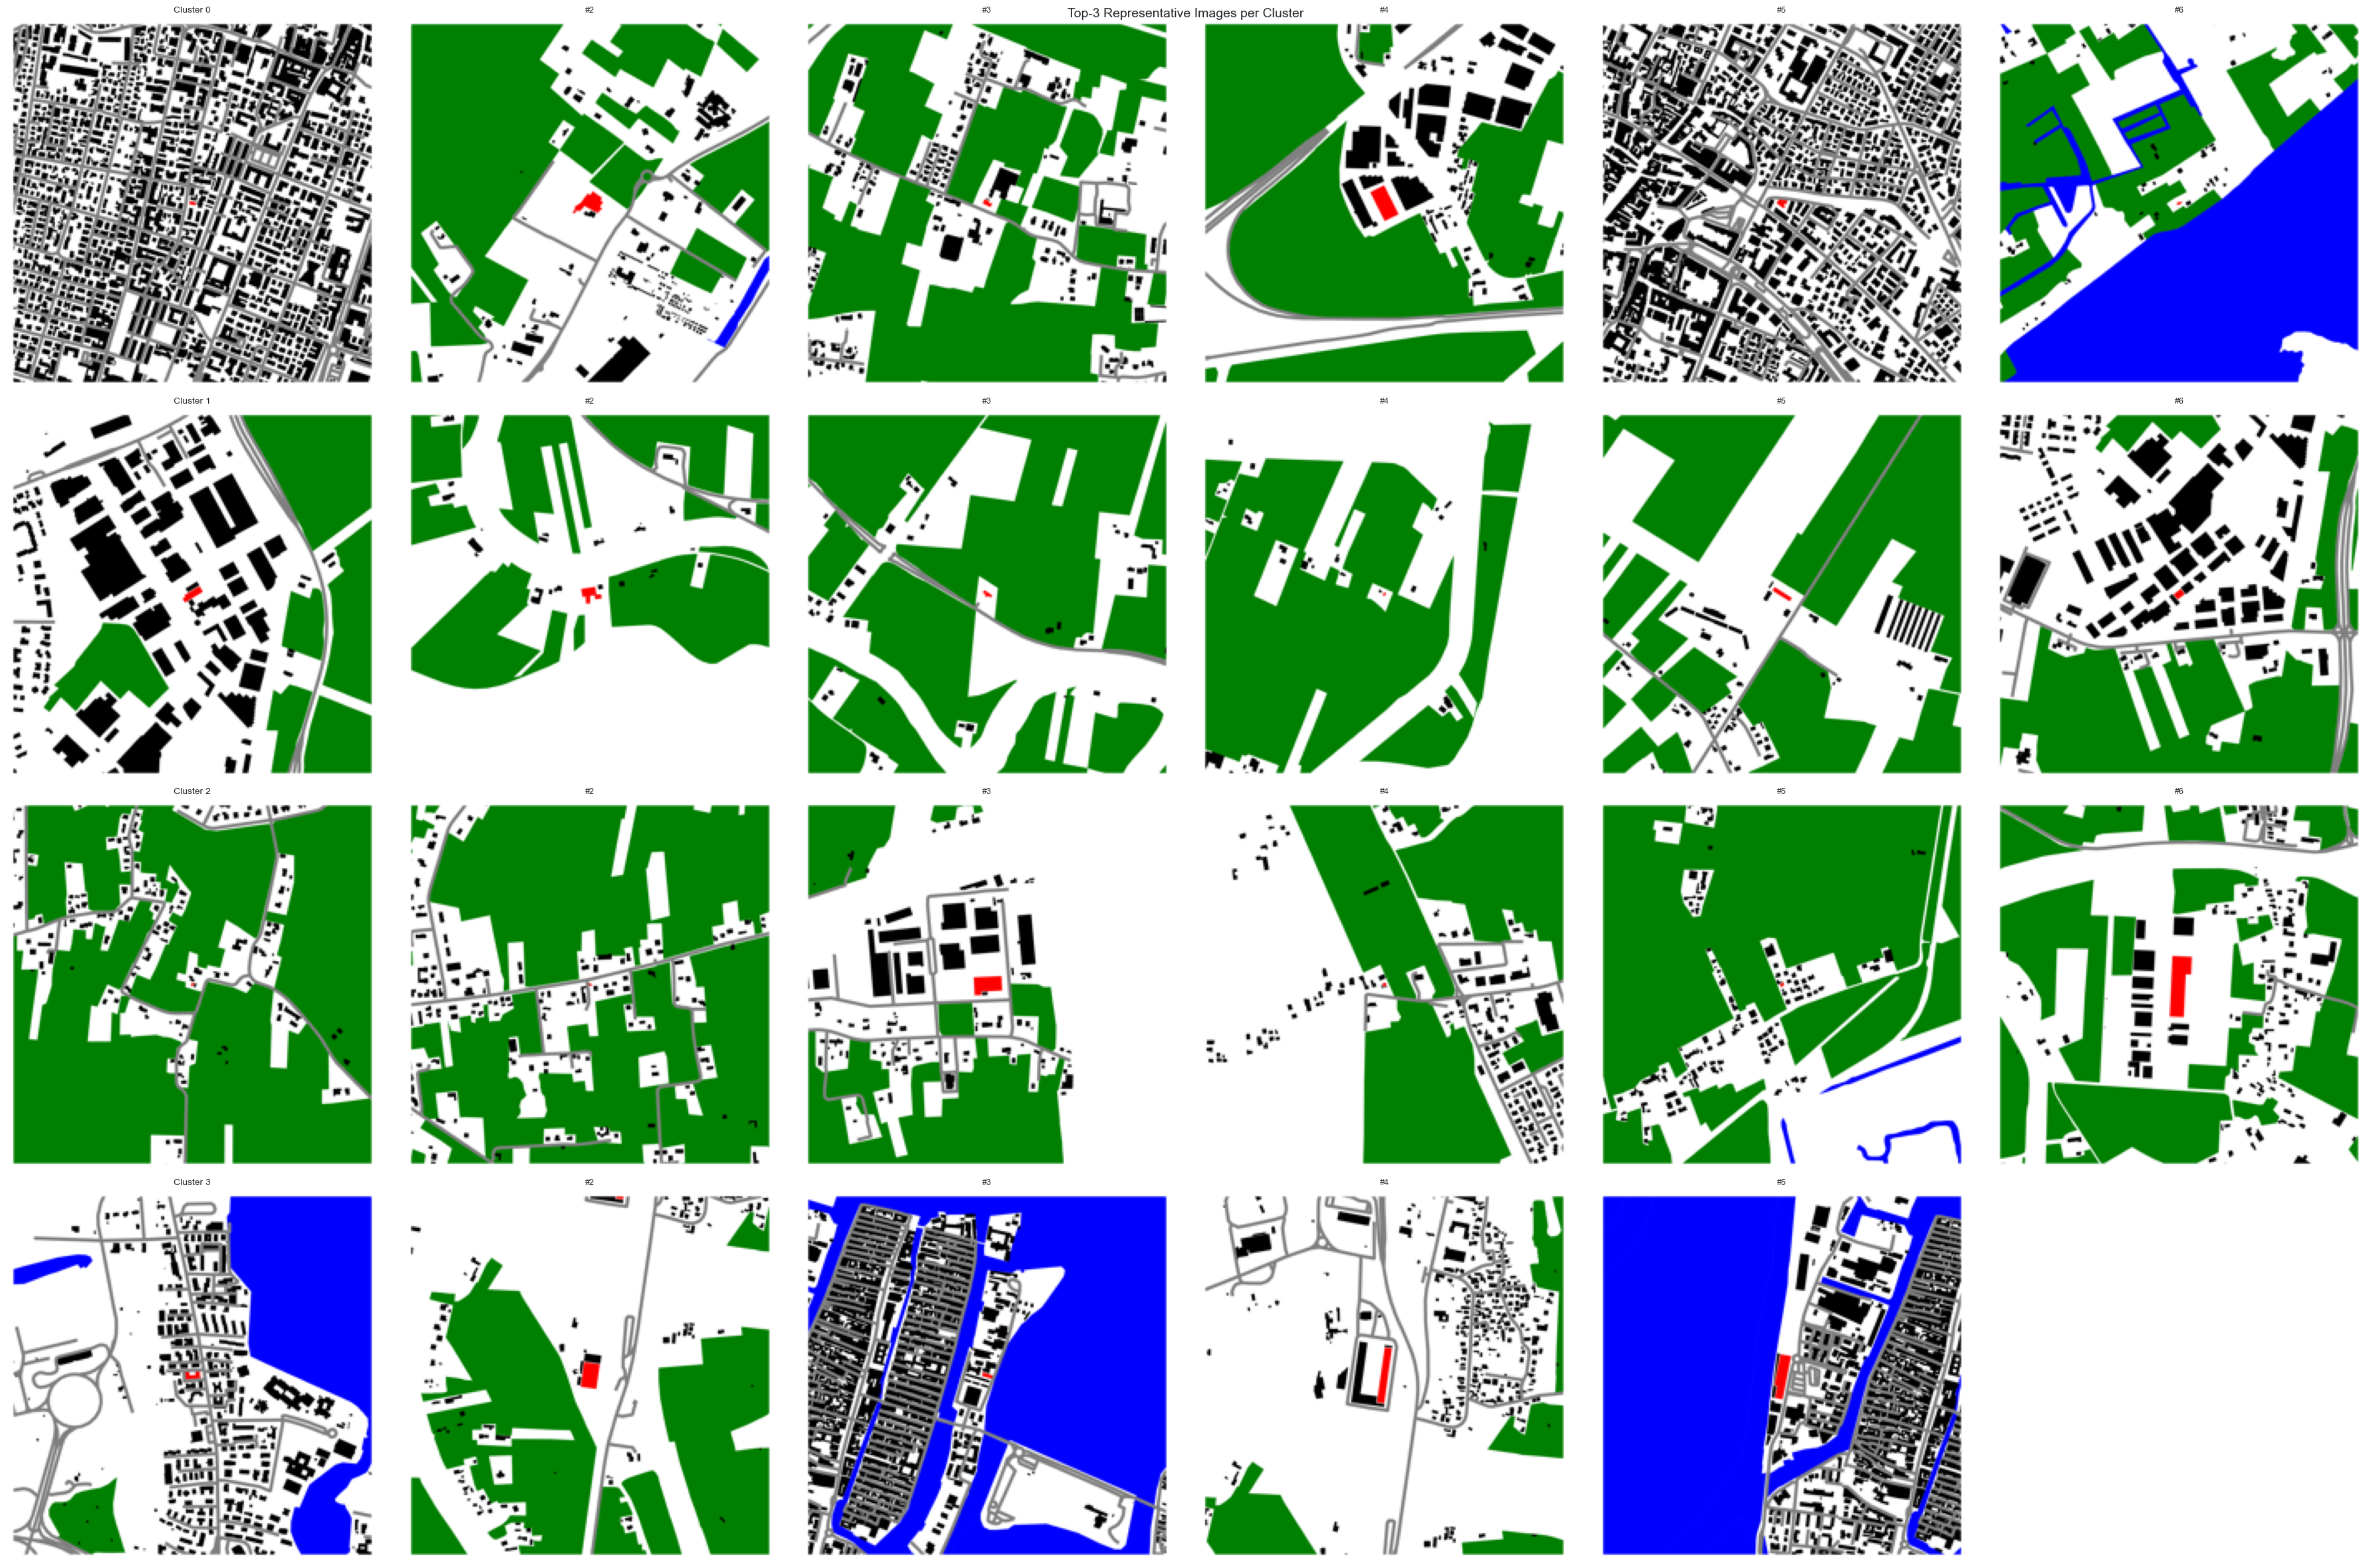

In [46]:
import matplotlib.pyplot as plt

topk = 6
representative_clusters = {}

for cluster_id in np.unique(labels):
    idx = np.where(labels == cluster_id)[0]
    cluster_points = X_pca[idx]
    # center = kmeans.cluster_centers_[cluster_id]
    center = np.mean(cluster_points, axis=0)
    distances = np.linalg.norm(cluster_points - center, axis=1)

    sorted_indices = idx[np.argsort(distances)[:topk]]
    representative_clusters[cluster_id] = sorted_indices

n_clusters = len(representative_clusters)

plt.figure(figsize=(topk * 6, n_clusters * 6))

for cluster_id, indices in representative_clusters.items():
    for rank, idx in enumerate(indices):
        plt_idx = cluster_id * topk + rank + 1  # subplot index
        plt.subplot(n_clusters, topk, plt_idx)
        img = img_list[idx]

        # 若图像归一化（0~1），需要乘回 255
        if img.max() <= 1.0:
            img = (img * 255).astype("uint8")

        plt.imshow(img)
        plt.axis("off")
        if rank == 0:
            plt.title(f"Cluster {cluster_id}", fontsize=10)
        else:
            plt.title(f"#{rank+1}", fontsize=9)

plt.suptitle("Top-3 Representative Images per Cluster", fontsize=14)
plt.tight_layout()
plt.show()


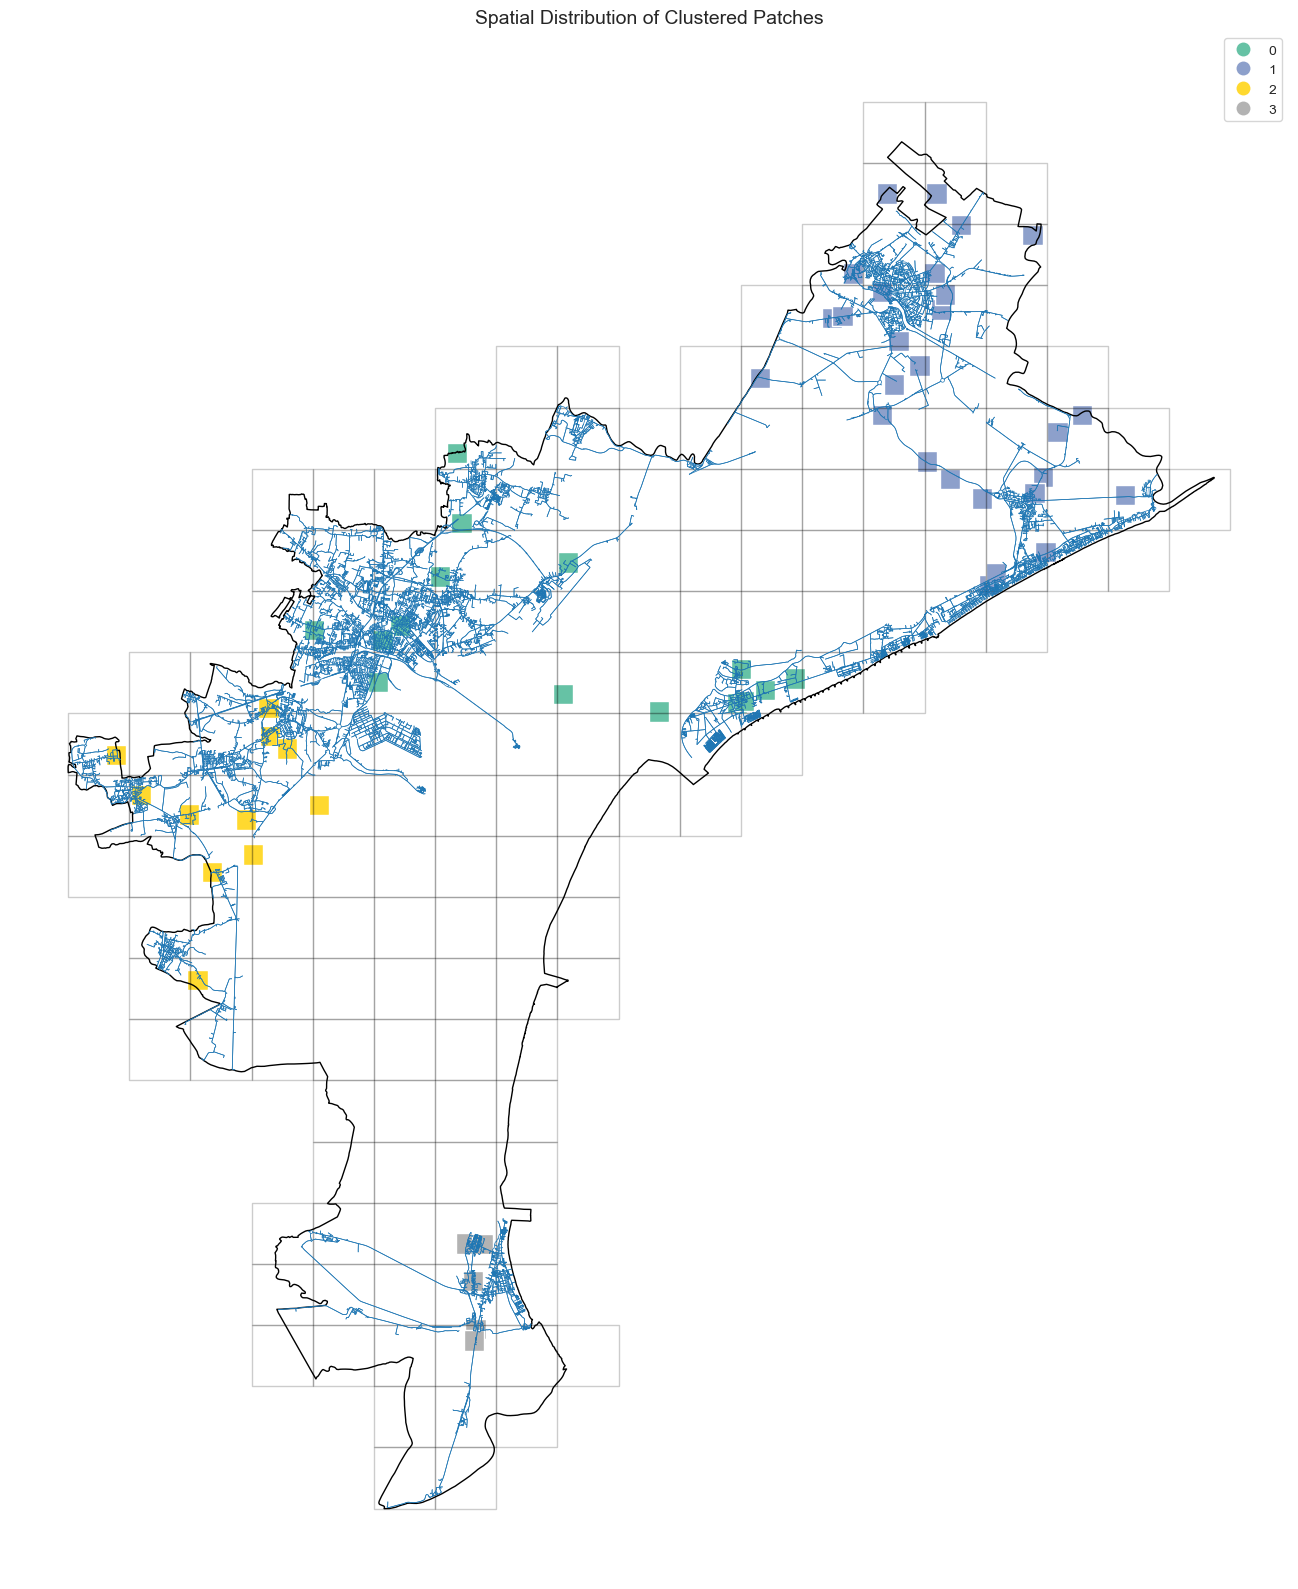

In [47]:
matched = matched.copy()
matched['cluster'] = labels  # 新增一列
import matplotlib.pyplot as plt
half_size = 500  # 即正方形边长1000

# 创建新几何列：以每个 matched 中心为中心构造正方形
matched['geometry'] = matched.geometry.apply(
    lambda pt: box(
        pt.x - half_size, pt.y - half_size,
        pt.x + half_size, pt.y + half_size
    )
)
matched_square = matched.set_geometry('geometry')
# 显示GWR的框架
fig, ax = plt.subplots(figsize=(20, 16))
matched_square .plot(column='cluster', cmap='Set2', categorical=True, legend=True, ax=ax)

ax.set_title("Spatial Distribution of Clustered Patches", fontsize=14)
ax.axis("off")
plt.tight_layout()
gdf_boundary=gpd.read_file("origin_data/00_Boundaries").to_crs(epsg=32632)
gdf_roads=gpd.read_file("origin_data/07_logistics_roads").to_crs(epsg=32632)


grid= gpd.read_file(r"processing_data\grid\grid_normalized_3000.geojson")
gdf_boundary.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1)
gdf_roads.plot(ax=ax,linewidth=0.5)

grid.plot(ax=ax,edgecolor="black",alpha=0.2,facecolor="none")
plt.show()
